In [16]:
#%matplotlib notebook
%matplotlib inline

import os, sys
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import copy

from evo.core import metrics
from evo.tools.settings import SETTINGS
from evo.tools import plot
from evo.core import sync
from evo.core.trajectory import PoseTrajectory3D

import rosbag
import transformations

In [17]:
### Simple loop ###

In [18]:
file = os.getcwd() + "/test1/2024-07-04-13-44-09"

In [19]:
# Extract KdVisual Pose

#file = os.getcwd() + "/2024-06-26-17-17-21"
topic = '/kdvisual_ros/pose'

proj_2d = False

kd_timestamp = np.array([])
kd_x = np.array([])
kd_y = np.array([])
kd_z = np.array([])
kd_roll = np.array([])
kd_pitch = np.array([])
kd_yaw = np.array([])
kd_q = np.array([])

bag = rosbag.Bag(file + '.bag')
for topic, msg, t in bag.read_messages(topics=[topic]):
    
    kd_timestamp = np.append(kd_timestamp, msg.header.stamp.to_sec())
    
    orientation_q = msg.pose.orientation
    orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
    (roll, pitch, yaw) = transformations.euler_from_quaternion (orientation_list)

    kd_x = np.append(kd_x, msg.pose.position.x)
    kd_y = np.append(kd_y, msg.pose.position.y)
    if not proj_2d:
        kd_z = np.append(kd_z, msg.pose.position.z)
    else:
        kd_z = np.append(kd_z, 0)

    kd_yaw = np.append(kd_yaw, yaw)
    kd_pitch = np.append(kd_pitch, pitch)
    kd_roll = np.append(kd_roll, roll)
    
    if not proj_2d:
        q = np.array(orientation_list)
    else:
        q = transformations.quaternion_from_euler (0, 0, yaw)
        
    if len(kd_q):
        kd_q = np.vstack((kd_q, q))
    else: 
        kd_q = np.append(kd_q, q)

bag.close()

print ('Processed', len(kd_timestamp), 'messages')

kd_timestamp = kd_timestamp - kd_timestamp[0]
kd_xyz = np.column_stack((kd_x, kd_y, kd_z))
traj_kd = PoseTrajectory3D(kd_xyz, kd_q, kd_timestamp)
print (traj_kd)

Processed 2539 messages
2539 poses, 17.395m path length, 203.476s duration


In [20]:
# Extract GT Pose

#file = os.getcwd() + "/2024-06-26-16-35-37"
topic = '/vrpn_client_node/Gemini0/pose'

proj_2d = False

gt_timestamp = np.array([])
gt_x = np.array([])
gt_y = np.array([])
gt_z = np.array([])
gt_roll = np.array([])
gt_pitch = np.array([])
gt_yaw = np.array([])
gt_q = np.array([])

bag = rosbag.Bag(file + '.bag')
for topic, msg, t in bag.read_messages(topics=[topic]):
    
    gt_timestamp = np.append(gt_timestamp, msg.header.stamp.to_sec())
    
    orientation_q = msg.pose.orientation
    orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
    (roll, pitch, yaw) = transformations.euler_from_quaternion (orientation_list)

    gt_x = np.append(gt_x, msg.pose.position.x)
    gt_y = np.append(gt_y, msg.pose.position.y)
    if not proj_2d:
        gt_z = np.append(gt_z, msg.pose.position.z)
    else:
        gt_z = np.append(gt_z, 0)

    gt_yaw = np.append(gt_yaw, yaw)
    gt_pitch = np.append(gt_pitch, pitch)
    gt_roll = np.append(gt_roll, roll)
    
    if not proj_2d:
        q = np.array(orientation_list)
    else:
        q = transformations.quaternion_from_euler (0, 0, yaw)
        
    if len(gt_q):
        gt_q = np.vstack((gt_q, q))
    else: 
        gt_q = np.append(gt_q, q)

bag.close()

print ('Processed', len(gt_timestamp), 'messages')

gt_timestamp = gt_timestamp - gt_timestamp[0]
gt_xyz = np.column_stack((gt_x, gt_y, gt_z))
traj_gt = PoseTrajectory3D(gt_xyz, gt_q, gt_timestamp)
print (traj_gt)

Processed 6094 messages
6094 poses, 13.627m path length, 203.330s duration


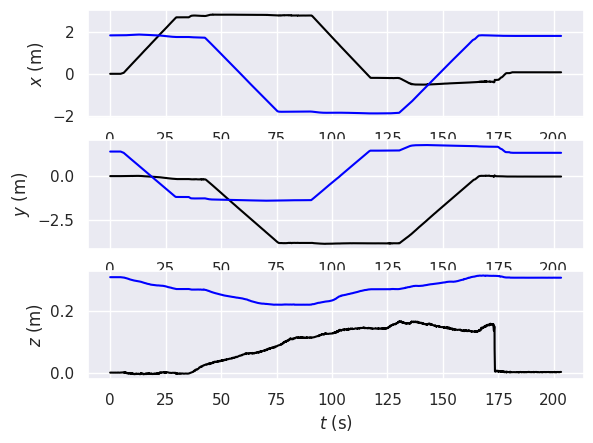

In [21]:
# Plot change in x y z axes (KdVisual = black & GT = blue)

max_diff = 0.01
#traj_kd_aligned = copy.deepcopy(traj_kd)
#traj_kd_aligned.align(traj_gt, correct_scale=False, correct_only_scale=False)
traj_gt, traj_kd = sync.associate_trajectories(traj_gt, traj_kd, max_diff)


fig, axarr = plt.subplots(3)
plot.traj_xyz(axarr, traj_kd)
plot.traj_xyz(axarr, traj_gt, color='blue')
plt.show()

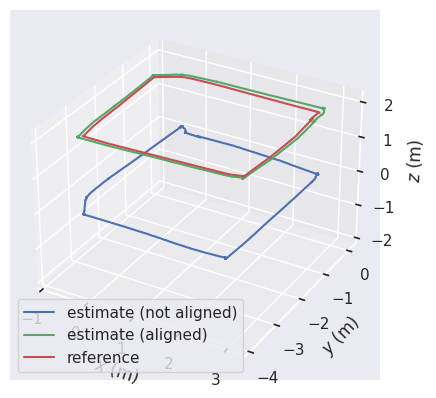

In [22]:
#Plot Trajectories (KdVisual aligned = green, GT = red, KdVisual unaligned = blue)

traj_kd_aligned = copy.deepcopy(traj_kd)
traj_kd_aligned.align(traj_gt, correct_scale=False, correct_only_scale=False)

fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_kd,
   "estimate (aligned)": traj_kd_aligned,
    "reference": traj_gt
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

In [23]:
# EVO Metrics 

from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

results_path = "results.png"

pose_relation = metrics.PoseRelation.translation_part
data = (traj_gt, traj_kd_aligned)

ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats = ape_metric.get_all_statistics()
print(ape_stats)

{'rmse': 0.09608943702427482, 'mean': 0.09363906736568708, 'median': 0.09118342753095345, 'std': 0.02156165509710223, 'min': 0.057785990729758756, 'max': 0.16352882008818917, 'sse': 14.653056513427977}


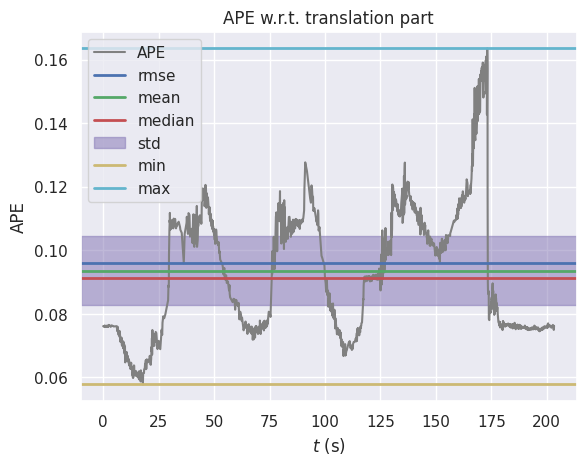

In [24]:
# Plot above Metrics 

seconds_from_start = [t - traj_kd_aligned.timestamps[0] for t in traj_kd_aligned.timestamps]
fig = plt.figure()
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

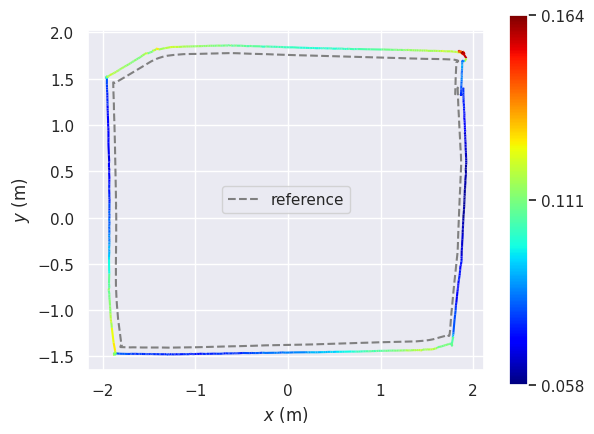

In [25]:
# Plot Trajectory in the xy plane

plot_mode = plot.PlotMode.xy

fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_gt, '--', "gray", "reference")
plot.traj_colormap(ax, traj_kd_aligned, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

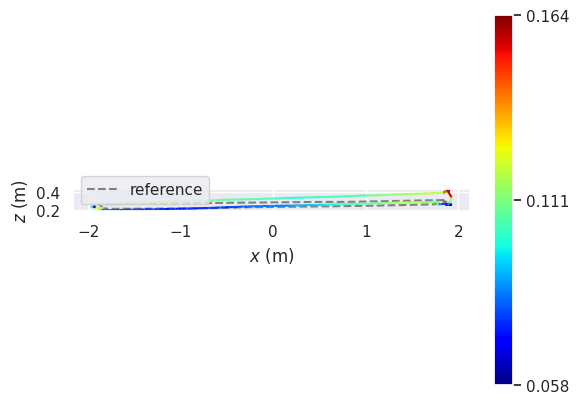

In [26]:
# Plot Trajectory in the xz plane

plot_mode = plot.PlotMode.xz
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_gt, '--', "gray", "reference")
plot.traj_colormap(ax, traj_kd_aligned, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

In [38]:
### Fig 8 Loop ###

In [39]:
file = os.getcwd() + "/test2/2024-07-04-13-55-12"

In [40]:
# Extract KdVisual Pose

#file = '/home/user/Downloads/KdRobotDockers-main/Gemini_ros_noetic/robot_ws/2024-06-26-13-15-29'
topic = '/kdvisual_ros/pose'

proj_2d = False

kd_timestamp = np.array([])
kd_x = np.array([])
kd_y = np.array([])
kd_z = np.array([])
kd_roll = np.array([])
kd_pitch = np.array([])
kd_yaw = np.array([])
kd_q = np.array([])

bag = rosbag.Bag(file + '.bag')
for topic, msg, t in bag.read_messages(topics=[topic]):
    
    kd_timestamp = np.append(kd_timestamp, msg.header.stamp.to_sec())
    
    orientation_q = msg.pose.orientation
    orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
    (roll, pitch, yaw) = transformations.euler_from_quaternion (orientation_list)

    kd_x = np.append(kd_x, msg.pose.position.x)
    kd_y = np.append(kd_y, msg.pose.position.y)
    if not proj_2d:
        kd_z = np.append(kd_z, msg.pose.position.z)
    else:
        kd_z = np.append(kd_z, 0)

    kd_yaw = np.append(kd_yaw, yaw)
    kd_pitch = np.append(kd_pitch, pitch)
    kd_roll = np.append(kd_roll, roll)
    
    if not proj_2d:
        q = np.array(orientation_list)
    else:
        q = transformations.quaternion_from_euler (0, 0, yaw)
        
    if len(kd_q):
        kd_q = np.vstack((kd_q, q))
    else: 
        kd_q = np.append(kd_q, q)

bag.close()

print ('Processed', len(kd_timestamp), 'messages')

kd_timestamp = kd_timestamp - kd_timestamp[0]
kd_xyz = np.column_stack((kd_x, kd_y, kd_z))
traj_kd = PoseTrajectory3D(kd_xyz, kd_q, kd_timestamp)
print (traj_kd)

Processed 2932 messages
2932 poses, 21.240m path length, 248.456s duration


In [41]:
# Extract GT Pose

#file = '/home/user/Downloads/KdRobotDockers-main/Gemini_ros_noetic/robot_ws/2024-06-26-11-00-25'
topic = '/vrpn_client_node/Gemini0/pose'

proj_2d = False

gt_timestamp = np.array([])
gt_x = np.array([])
gt_y = np.array([])
gt_z = np.array([])
gt_roll = np.array([])
gt_pitch = np.array([])
gt_yaw = np.array([])
gt_q = np.array([])

bag = rosbag.Bag(file + '.bag')
for topic, msg, t in bag.read_messages(topics=[topic]):
    
    gt_timestamp = np.append(gt_timestamp, msg.header.stamp.to_sec())
    
    orientation_q = msg.pose.orientation
    orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
    (roll, pitch, yaw) = transformations.euler_from_quaternion (orientation_list)

    gt_x = np.append(gt_x, msg.pose.position.x)
    gt_y = np.append(gt_y, msg.pose.position.y)
    if not proj_2d:
        gt_z = np.append(gt_z, msg.pose.position.z)
    else:
        gt_z = np.append(gt_z, 0)

    gt_yaw = np.append(gt_yaw, yaw)
    gt_pitch = np.append(gt_pitch, pitch)
    gt_roll = np.append(gt_roll, roll)
    
    if not proj_2d:
        q = np.array(orientation_list)
    else:
        q = transformations.quaternion_from_euler (0, 0, yaw)
        
    if len(gt_q):
        gt_q = np.vstack((gt_q, q))
    else: 
        gt_q = np.append(gt_q, q)

bag.close()

print ('Processed', len(gt_timestamp), 'messages')

gt_timestamp = gt_timestamp - gt_timestamp[0]
gt_xyz = np.column_stack((gt_x, gt_y, gt_z))
print(gt_xyz)
print(gt_q)
traj_gt = PoseTrajectory3D(gt_xyz, gt_q, gt_timestamp)
print (traj_gt)

Processed 7334 messages
[[1.80680263 1.33314133 0.30857059]
 [1.80682421 1.33313394 0.30854648]
 [1.80685115 1.3331759  0.30856407]
 ...
 [1.80834532 1.35072887 0.30887684]
 [1.80836141 1.35075963 0.30888593]
 [1.8083334  1.35077846 0.30886385]]
[[ 4.70381742e-03 -7.89348211e-04 -2.98508890e-02  9.99543011e-01]
 [ 4.51661414e-03 -9.40050464e-04 -3.00061032e-02  9.99539077e-01]
 [ 4.50859405e-03 -8.77902727e-04 -2.99280677e-02  9.99541521e-01]
 ...
 [ 3.81039688e-03 -4.53274744e-03 -8.28961190e-03  9.99948084e-01]
 [ 4.04759031e-03 -4.81978012e-03 -8.28433782e-03  9.99945879e-01]
 [ 4.06095572e-03 -4.96904133e-03 -8.16342141e-03  9.99946058e-01]]
7334 poses, 18.002m path length, 248.330s duration


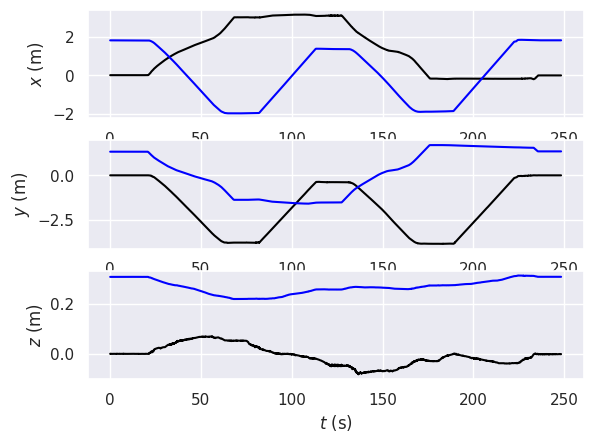

In [42]:
# Plot change in x y z axes (KdVisual = black & GT = blue)

max_diff = 0.01
traj_gt, traj_kd = sync.associate_trajectories(traj_gt, traj_kd, max_diff)


fig, axarr = plt.subplots(3)
plot.traj_xyz(axarr, traj_kd)
plot.traj_xyz(axarr, traj_gt, color='blue')
plt.show()

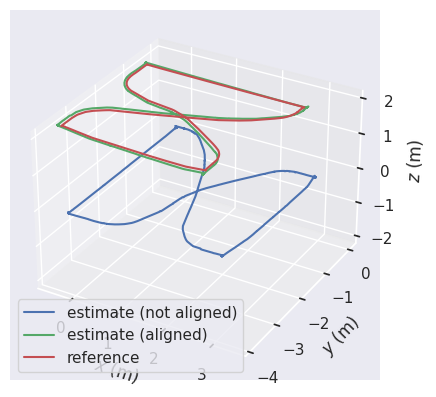

In [43]:
#Plot Trajectories (KdVisual aligned = green, GT = red, KdVisual unaligned = blue)

traj_kd_aligned = copy.deepcopy(traj_kd)
traj_kd_aligned.align(traj_gt, correct_scale=False, correct_only_scale=False)

fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_kd,
   "estimate (aligned)": traj_kd_aligned,
    "reference": traj_gt
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

In [44]:
# EVO Metrics 

from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

results_path = "results.png"

pose_relation = metrics.PoseRelation.translation_part
data = (traj_gt, traj_kd_aligned)

ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats = ape_metric.get_all_statistics()
print(ape_stats)

{'rmse': 0.09818152194895513, 'mean': 0.09553674483605583, 'median': 0.09105072775120508, 'std': 0.022634964951232395, 'min': 0.023607588887298463, 'max': 0.1505400318696972, 'sse': 18.546612049258115}


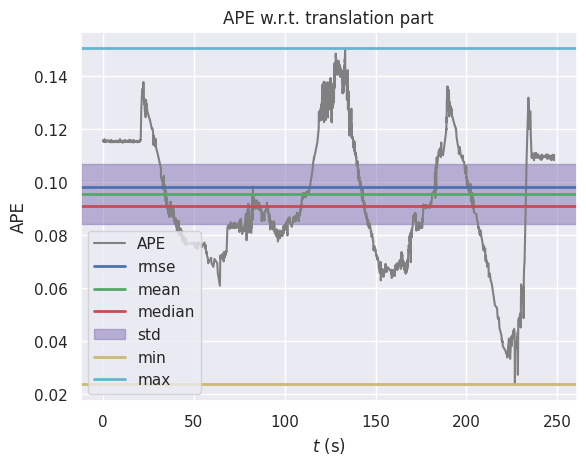

In [45]:
# Plot above Metrics 

seconds_from_start = [t - traj_kd_aligned.timestamps[0] for t in traj_kd_aligned.timestamps]
fig = plt.figure()
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

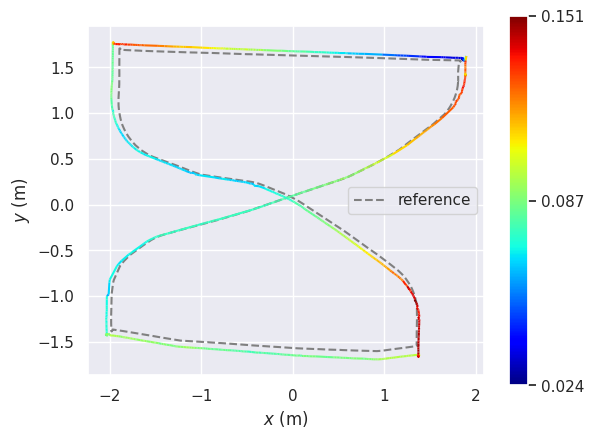

In [46]:
# Plot Trajectory in the xy plane

plot_mode = plot.PlotMode.xy

fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_gt, '--', "gray", "reference")
plot.traj_colormap(ax, traj_kd_aligned, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

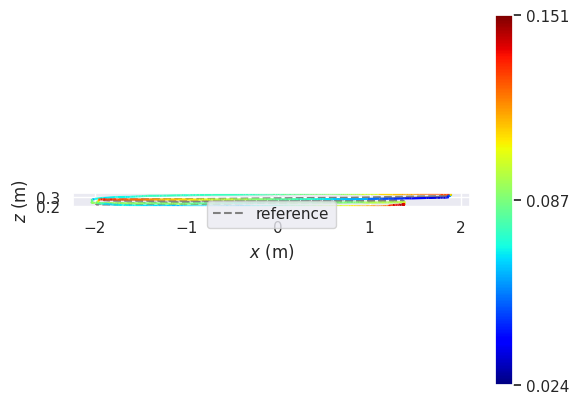

In [47]:
# Plot Trajectory in the xz plane

plot_mode = plot.PlotMode.xz
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_gt, '--', "gray", "reference")
plot.traj_colormap(ax, traj_kd_aligned, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

In [52]:
### Thorough Loop ###

In [53]:
file = os.getcwd() + "/test3/2024-07-04-14-18-26"

In [54]:
# Extract KdVisual Pose

#file = '/home/user/Downloads/KdRobotDockers-main/Gemini_ros_noetic/robot_ws/2024-06-27-09-48-08'
topic = '/kdvisual_ros/pose'

proj_2d = False

kd_timestamp = np.array([])
kd_x = np.array([])
kd_y = np.array([])
kd_z = np.array([])
kd_roll = np.array([])
kd_pitch = np.array([])
kd_yaw = np.array([])
kd_q = np.array([])

bag = rosbag.Bag(file + '.bag')
for topic, msg, t in bag.read_messages(topics=[topic]):
    
    kd_timestamp = np.append(kd_timestamp, msg.header.stamp.to_sec())
    
    orientation_q = msg.pose.orientation
    orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
    (roll, pitch, yaw) = transformations.euler_from_quaternion (orientation_list)

    kd_x = np.append(kd_x, msg.pose.position.x)
    kd_y = np.append(kd_y, msg.pose.position.y)
    if not proj_2d:
        kd_z = np.append(kd_z, msg.pose.position.z)
    else:
        kd_z = np.append(kd_z, 0)

    kd_yaw = np.append(kd_yaw, yaw)
    kd_pitch = np.append(kd_pitch, pitch)
    kd_roll = np.append(kd_roll, roll)
    
    if not proj_2d:
        q = np.array(orientation_list)
    else:
        q = transformations.quaternion_from_euler (0, 0, yaw)
        
    if len(kd_q):
        kd_q = np.vstack((kd_q, q))
    else: 
        kd_q = np.append(kd_q, q)

bag.close()

print ('Processed', len(kd_timestamp), 'messages')

kd_timestamp = kd_timestamp - kd_timestamp[0]
kd_xyz = np.column_stack((kd_x, kd_y, kd_z))
traj_kd = PoseTrajectory3D(kd_xyz, kd_q, kd_timestamp)
print (traj_kd)

Processed 4536 messages
4536 poses, 36.265m path length, 360.833s duration


In [55]:
# Extract GT Pose

#file = '/home/user/Downloads/KdRobotDockers-main/Gemini_ros_noetic/robot_ws/2024-06-16-Thorough-loop'
topic = '/vrpn_client_node/Gemini0/pose'

proj_2d = False

gt_timestamp = np.array([])
gt_x = np.array([])
gt_y = np.array([])
gt_z = np.array([])
gt_roll = np.array([])
gt_pitch = np.array([])
gt_yaw = np.array([])
gt_q = np.array([])

bag = rosbag.Bag(file + '.bag')
for topic, msg, t in bag.read_messages(topics=[topic]):
    
    gt_timestamp = np.append(gt_timestamp, msg.header.stamp.to_sec())
    
    orientation_q = msg.pose.orientation
    orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
    (roll, pitch, yaw) = transformations.euler_from_quaternion (orientation_list)

    gt_x = np.append(gt_x, msg.pose.position.x)
    gt_y = np.append(gt_y, msg.pose.position.y)
    if not proj_2d:
        gt_z = np.append(gt_z, msg.pose.position.z)
    else:
        gt_z = np.append(gt_z, 0)

    gt_yaw = np.append(gt_yaw, yaw)
    gt_pitch = np.append(gt_pitch, pitch)
    gt_roll = np.append(gt_roll, roll)
    
    if not proj_2d:
        q = np.array(orientation_list)
    else:
        q = transformations.quaternion_from_euler (0, 0, yaw)
        
    if len(gt_q):
        gt_q = np.vstack((gt_q, q))
    else: 
        gt_q = np.append(gt_q, q)

bag.close()

print ('Processed', len(gt_timestamp), 'messages')

gt_timestamp = gt_timestamp - gt_timestamp[0]
gt_xyz = np.column_stack((gt_x, gt_y, gt_z))
print(gt_xyz)
print(gt_q)
traj_gt = PoseTrajectory3D(gt_xyz, gt_q, gt_timestamp)
print (traj_gt)

Processed 10821 messages
[[1.82890558 1.31992006 0.30894363]
 [1.82888532 1.31997311 0.30899772]
 [1.82892132 1.31998134 0.3089723 ]
 ...
 [1.79999745 1.32491958 0.30839559]
 [1.79998159 1.32492173 0.308359  ]
 [1.8000288  1.32496274 0.30835515]]
[[ 0.00426981 -0.00364049 -0.02037804  0.9997766 ]
 [ 0.00418181 -0.00357938 -0.02039862  0.99977678]
 [ 0.00409477 -0.00373514 -0.02039431  0.99977666]
 ...
 [ 0.00613924 -0.00159676 -0.03867136  0.99923187]
 [ 0.00627397 -0.0017764  -0.03858482  0.99923408]
 [ 0.00614137 -0.00155887 -0.03867324  0.99923182]]
10821 poses, 25.903m path length, 360.770s duration


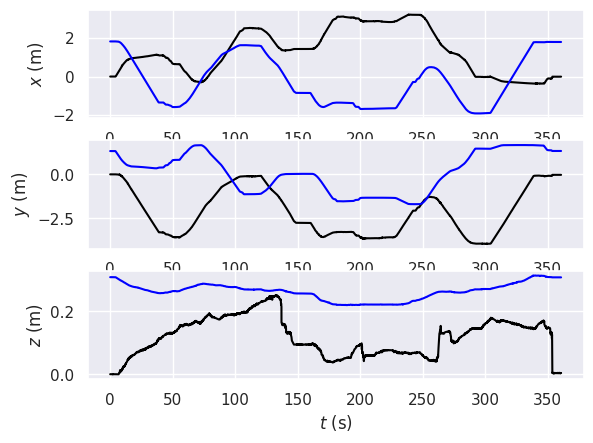

In [56]:
# Plot change in x y z axes (KdVisual = black & GT = blue)

max_diff = 0.01
traj_gt, traj_kd = sync.associate_trajectories(traj_gt, traj_kd, max_diff)


fig, axarr = plt.subplots(3)
plot.traj_xyz(axarr, traj_kd)
plot.traj_xyz(axarr, traj_gt, color='blue')
plt.show()

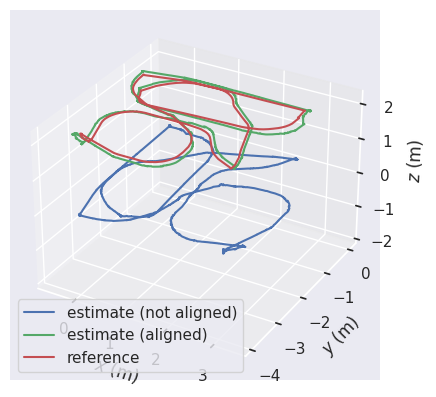

In [57]:
#Plot Trajectories (KdVisual aligned = green, GT = red, KdVisual unaligned = blue)

traj_kd_aligned = copy.deepcopy(traj_kd)
traj_kd_aligned.align(traj_gt, correct_scale=False, correct_only_scale=False)

fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_kd,
   "estimate (aligned)": traj_kd_aligned,
    "reference": traj_gt
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

In [58]:
# EVO Metrics 

from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

results_path = "results.png"

pose_relation = metrics.PoseRelation.translation_part
data = (traj_gt, traj_kd_aligned)

ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats = ape_metric.get_all_statistics()
print(ape_stats)

{'rmse': 0.10610083311051657, 'mean': 0.09666030825049687, 'median': 0.09318890886139335, 'std': 0.04375124678983005, 'min': 0.009088571307493964, 'max': 0.19953589055625431, 'sse': 32.1285818893722}


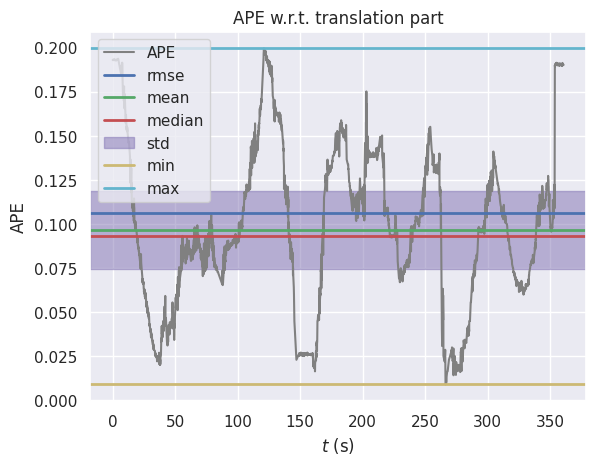

In [59]:
# Plot above Metrics 

seconds_from_start = [t - traj_kd_aligned.timestamps[0] for t in traj_kd_aligned.timestamps]
fig = plt.figure()
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

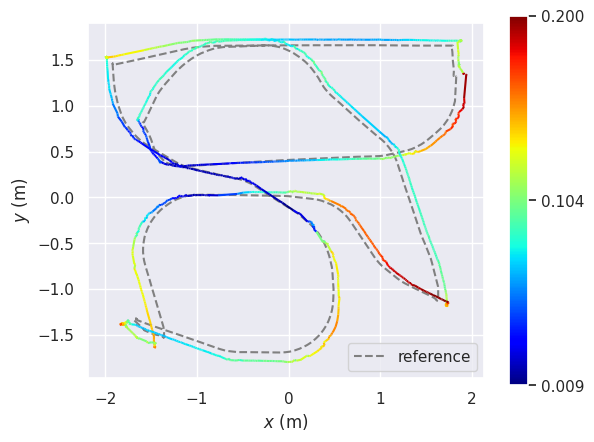

In [60]:
# Plot Trajectory in the xy plane

plot_mode = plot.PlotMode.xy

fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_gt, '--', "gray", "reference")
plot.traj_colormap(ax, traj_kd_aligned, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

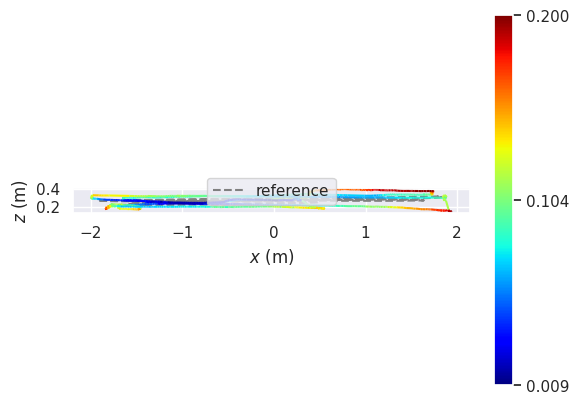

In [61]:
# Plot Trajectory in the xz plane

plot_mode = plot.PlotMode.xz
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_gt, '--', "gray", "reference")
plot.traj_colormap(ax, traj_kd_aligned, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

In [62]:
### Partial Loop ###

In [63]:
file = os.getcwd() + "/test4/2024-07-04-14-35-45"

In [64]:
# Extract KdVisual Pose

#file = '/home/user/Downloads/KdRobotDockers-main/Gemini_ros_noetic/robot_ws/2024-06-27-10-05-44'
topic = '/kdvisual_ros/pose'

proj_2d = False

kd_timestamp = np.array([])
kd_x = np.array([])
kd_y = np.array([])
kd_z = np.array([])
kd_roll = np.array([])
kd_pitch = np.array([])
kd_yaw = np.array([])
kd_q = np.array([])

bag = rosbag.Bag(file + '.bag')
for topic, msg, t in bag.read_messages(topics=[topic]):
    
    kd_timestamp = np.append(kd_timestamp, msg.header.stamp.to_sec())
    
    orientation_q = msg.pose.orientation
    orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
    (roll, pitch, yaw) = transformations.euler_from_quaternion (orientation_list)

    kd_x = np.append(kd_x, msg.pose.position.x)
    kd_y = np.append(kd_y, msg.pose.position.y)
    if not proj_2d:
        kd_z = np.append(kd_z, msg.pose.position.z)
    else:
        kd_z = np.append(kd_z, 0)

    kd_yaw = np.append(kd_yaw, yaw)
    kd_pitch = np.append(kd_pitch, pitch)
    kd_roll = np.append(kd_roll, roll)
    
    if not proj_2d:
        q = np.array(orientation_list)
    else:
        q = transformations.quaternion_from_euler (0, 0, yaw)
        
    if len(kd_q):
        kd_q = np.vstack((kd_q, q))
    else: 
        kd_q = np.append(kd_q, q)

bag.close()

print ('Processed', len(kd_timestamp), 'messages')

kd_timestamp = kd_timestamp - kd_timestamp[0]
kd_xyz = np.column_stack((kd_x, kd_y, kd_z))
traj_kd = PoseTrajectory3D(kd_xyz, kd_q, kd_timestamp)
print (traj_kd)

Processed 2412 messages
2412 poses, 18.019m path length, 203.133s duration


In [65]:
# Extract GT Pose

#file = '/home/user/Downloads/KdRobotDockers-main/Gemini_ros_noetic/robot_ws/2024-06-16-Partial-loop'
topic = '/vrpn_client_node/Gemini0/pose'

proj_2d = False

gt_timestamp = np.array([])
gt_x = np.array([])
gt_y = np.array([])
gt_z = np.array([])
gt_roll = np.array([])
gt_pitch = np.array([])
gt_yaw = np.array([])
gt_q = np.array([])

bag = rosbag.Bag(file + '.bag')
for topic, msg, t in bag.read_messages(topics=[topic]):
    
    gt_timestamp = np.append(gt_timestamp, msg.header.stamp.to_sec())
    
    orientation_q = msg.pose.orientation
    orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
    (roll, pitch, yaw) = transformations.euler_from_quaternion (orientation_list)

    gt_x = np.append(gt_x, msg.pose.position.x)
    gt_y = np.append(gt_y, msg.pose.position.y)
    if not proj_2d:
        gt_z = np.append(gt_z, msg.pose.position.z)
    else:
        gt_z = np.append(gt_z, 0)

    gt_yaw = np.append(gt_yaw, yaw)
    gt_pitch = np.append(gt_pitch, pitch)
    gt_roll = np.append(gt_roll, roll)
    
    if not proj_2d:
        q = np.array(orientation_list)
    else:
        q = transformations.quaternion_from_euler (0, 0, yaw)
        
    if len(gt_q):
        gt_q = np.vstack((gt_q, q))
    else: 
        gt_q = np.append(gt_q, q)

bag.close()

print ('Processed', len(gt_timestamp), 'messages')

gt_timestamp = gt_timestamp - gt_timestamp[0]
gt_xyz = np.column_stack((gt_x, gt_y, gt_z))
print(gt_xyz)
print(gt_q)
traj_gt = PoseTrajectory3D(gt_xyz, gt_q, gt_timestamp)
print (traj_gt)

Processed 6079 messages
[[1.83135974 1.34296262 0.3094047 ]
 [1.8314122  1.34307778 0.30950284]
 [1.83141446 1.34311032 0.30945033]
 ...
 [1.82451999 1.32569563 0.30883059]
 [1.82450747 1.32574069 0.30887434]
 [1.82453239 1.32579756 0.30884805]]
[[ 0.00474553 -0.00361322 -0.01551613  0.99986184]
 [ 0.00484393 -0.00359273 -0.01571606  0.99985832]
 [ 0.00503403 -0.00354896 -0.01583721  0.99985564]
 ...
 [ 0.00490681 -0.00455776 -0.00656818  0.99995601]
 [ 0.00462247 -0.00467644 -0.00650588  0.9999572 ]
 [ 0.00466344 -0.00484979 -0.00649366  0.99995631]]
6079 poses, 13.049m path length, 202.960s duration


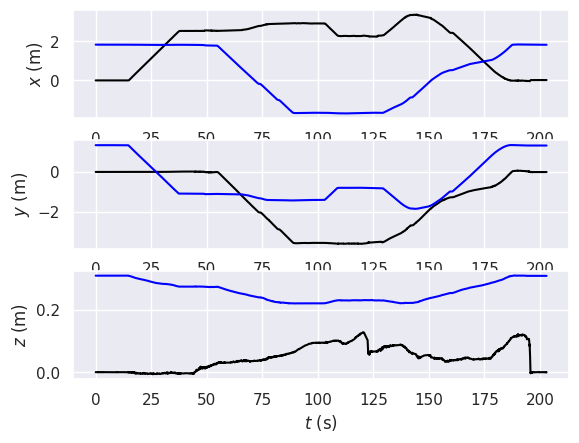

In [66]:
# Plot change in x y z axes (KdVisual = black & GT = blue)

max_diff = 0.01
traj_gt, traj_kd = sync.associate_trajectories(traj_gt, traj_kd, max_diff)


fig, axarr = plt.subplots(3)
plot.traj_xyz(axarr, traj_kd)
plot.traj_xyz(axarr, traj_gt, color='blue')
plt.show()

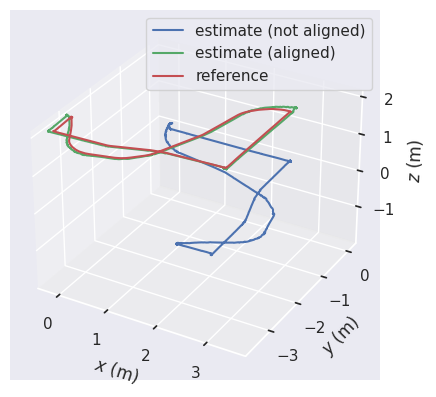

In [67]:
#Plot Trajectories (KdVisual aligned = green, GT = red, KdVisual unaligned = blue)

traj_kd_aligned = copy.deepcopy(traj_kd)
traj_kd_aligned.align(traj_gt, correct_scale=False, correct_only_scale=False)

fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_kd,
   "estimate (aligned)": traj_kd_aligned,
    "reference": traj_gt
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

In [68]:
# EVO Metrics 

from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

results_path = "results.png"

pose_relation = metrics.PoseRelation.translation_part
data = (traj_gt, traj_kd_aligned)

ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats = ape_metric.get_all_statistics()
print(ape_stats)

{'rmse': 0.06927853395365084, 'mean': 0.06337909963888723, 'median': 0.05755632289702936, 'std': 0.027975078118410275, 'min': 0.017121815743682444, 'max': 0.15199462045538276, 'sse': 6.997693258946509}


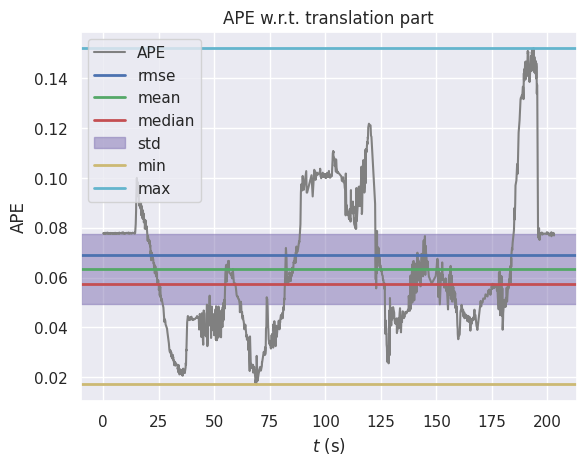

In [69]:
# Plot above Metrics 

seconds_from_start = [t - traj_kd_aligned.timestamps[0] for t in traj_kd_aligned.timestamps]
fig = plt.figure()
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

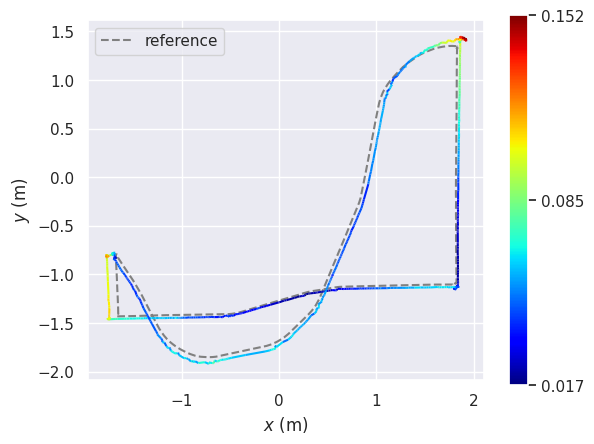

In [70]:
# Plot Trajectory in the xy plane

plot_mode = plot.PlotMode.xy

fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_gt, '--', "gray", "reference")
plot.traj_colormap(ax, traj_kd_aligned, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

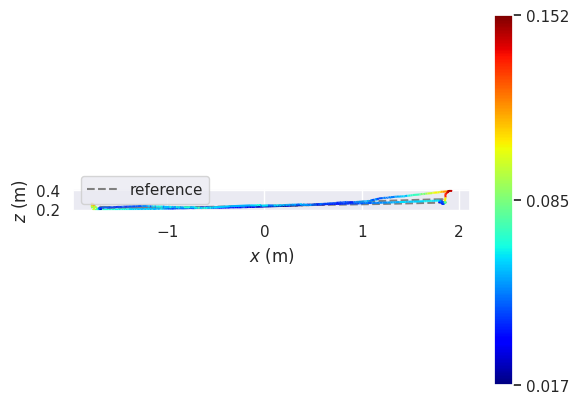

In [71]:
# Plot Trajectory in the xz plane

plot_mode = plot.PlotMode.xz
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_gt, '--', "gray", "reference")
plot.traj_colormap(ax, traj_kd_aligned, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()